In [1]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import sys
sys.path.append('../Codes/')
from models import *
from Epi_models import*
from functions import *
import networkx as nx
import matplotlib.animation as animation
import seaborn
from matplotlib.lines import Line2D
import pickle

def node_degrees(Amat):
        return Amat.sum(axis=0).reshape(N,1)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as ticker

Text_files_path = '../../../../Dropbox/Research/Epidemiology_2020/Text_files/'

%autosave 60

Autosaving every 60 seconds


## The Network
The network is generated usign the barabasi-albert algorithm. It has a heavy-tailed degree distribution characterized by a power-law behaviour and a exponential cutoff.

In [2]:
#----Load data network of contacts----
N = 2000
infile_k = open(Text_files_path+'Stochastic/Networks/barabasi-albert/k.pck','rb')
k = pickle.load(infile_k)
infile_k.close()
infile_p_k = open(Text_files_path+'Stochastic/Networks/barabasi-albert/p_k.pck','rb')
p_k = pickle.load(infile_p_k)
infile_p_k.close()

meanDegree = np.sum(k*p_k)
meanDegree2 = np.sum(k**2*p_k)
print(meanDegree)
print(np.max(k))

3.9960271618768215
265


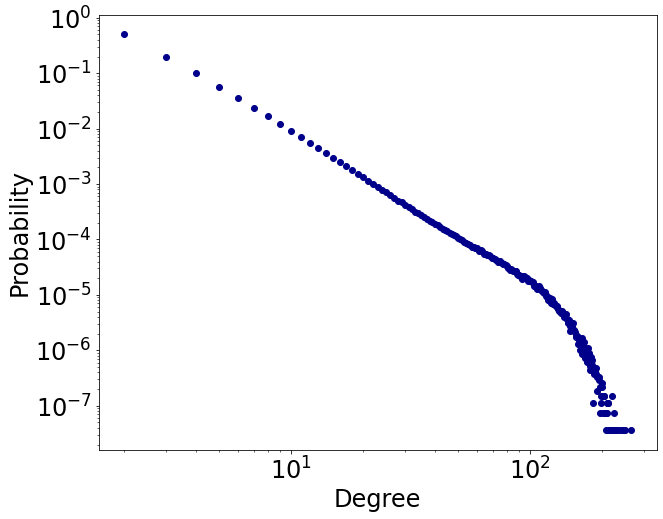

In [3]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(k[1:], p_k[1:], 'o', color = 'darkblue')
my_plot_layout(ax=ax, xlabel='Degree', ylabel='Probability', xscale = 'log', yscale = 'log')
#fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/degree_distribution.png')

In [4]:
colors_R = plt.cm.Paired(range(8))
N = 2000
print('N:', N)
gamma = 1/6
print('Gamma:', gamma)
sigma = 1000
print('Sigma:', sigma)
# I defined the R0 values for the SIR model and then get the values of beta
R0s = np.array([4.5, 3.0, 2.0, 1.2, 0.8]) #for p=1.0 I don't take into account R0=0.8
betas = R0s*gamma
print('betas:', betas)
R0_es = np.sqrt(1-4*((sigma*gamma-sigma*betas)/(sigma+gamma)**2))
Ts = 1-((meanDegree)/(meanDegree+R0s))
T_c = (meanDegree)/(meanDegree2-meanDegree)
R0_ns = Ts/T_c
print('T_c:', T_c)
print('Ts:', Ts)
print('R0s:', R0s)
print('R0_es:', R0_es)
print('R0_ns:', R0_ns)
tau = 1/gamma
tau_e = 2*(gamma+sigma)**(-1)
print('tau:', tau)
print('tau_e:', tau_e)

N: 2000
Gamma: 0.16666666666666666
Sigma: 1000
betas: [0.75       0.5        0.33333333 0.2        0.13333333]
T_c: 0.09242430412921085
Ts: [0.52965932 0.4288148  0.33355419 0.23094567 0.16680473]
R0s: [4.5 3.  2.  1.2 0.8]
R0_es: [1.0011656  1.00066622 1.00033317 1.00006664 0.99993335]
R0_ns: [5.7307364  4.63963246 3.60894459 2.49875481 1.80477125]
tau: 6.0
tau_e: 0.0019996667222129645


## What is the probability of establishment?

5297
7182
13029
15307
28298


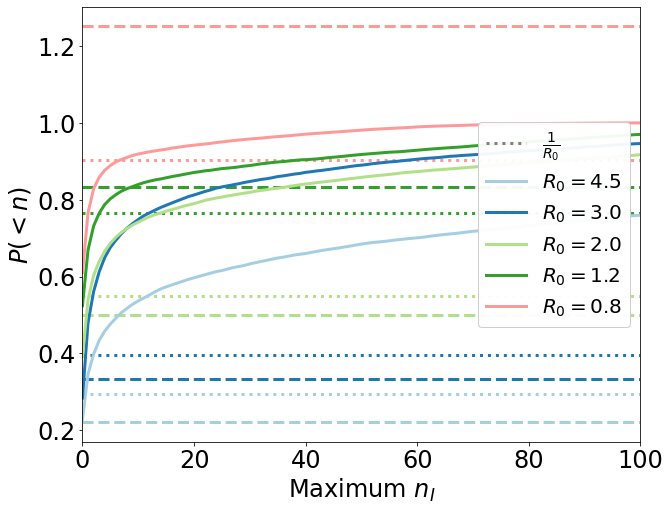

In [5]:
lines_symbols = [Line2D([0], [0], color='grey', linewidth=3, linestyle='dotted', ms = 8)]
labels_symbols = [r'$\frac{1}{R_0}$']


fig, ax = plt.subplots(figsize = (10,8))
p=0.0
sigma=1000
gamma = 1/6
if(p==0.0):
    R0s = np.array([4.5, 3.0, 2.0, 1.2, 0.8])
if(p==1.0):
    R0s = np.array([4.5, 3.0, 2.0, 1.2])    
for i, R0 in enumerate(R0s):
    data_I = np.loadtxt(Text_files_path+'Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(R0, sigma, N, p))
    data_nodes = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/stats_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(R0, sigma, N, p))
    nodes_ext , nodes_succ, I_ext, I_succ, max_values = sort_nodes(p=p, beta=R0*gamma, sigma=sigma, gamma=gamma, data_I = data_I, data_nodes = data_nodes)
    n_ext = len(nodes_ext[:,0])
    print(n_ext)
    prob_ext = n_ext/len(data_nodes[:,0])
    data_hist = numpy.histogram(max_values, bins = range(0,int(max(max_values))+2, 1), density =True);
    ax.plot(data_hist[1][:-1], np.cumsum(data_hist[0]), '-', color = colors_R[i], linewidth = 3, label = r'$R_0=$%.1f'%(R0))
    #ax.plot(data_hist[1][:-1], data_hist[0], '-', color = color_Rs[i], linewidth = 3, alpha = 0.3)
    ax.hlines(1/(R0), 0,int(max(max_values))+2, color = colors_R[i], linewidth=3, linestyle='dashed' )
    ax.hlines(prob_ext, 0,int(max(max_values))+2, color = colors_R[i], linewidth=3, linestyle='dotted' )

my_plot_layout(ax = ax, xlabel=r'Maximum $n_{{I}}$', ylabel=r'$P(<n)$')
ax.set_xlim(0, 100)
#ax.set_ylim(0, 10)
handles, labels = ax.get_legend_handles_labels()
ax.legend(np.concatenate((lines_symbols,handles)), np.concatenate((labels_symbols,labels)) , fontsize = 20, loc = 5, framealpha=.95)
#fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/maximum_ni_1_sigma_%.2f_p%.1f.pdf'%(sigma,p))


## What is the probability of epidemic as a function of $R_0$?

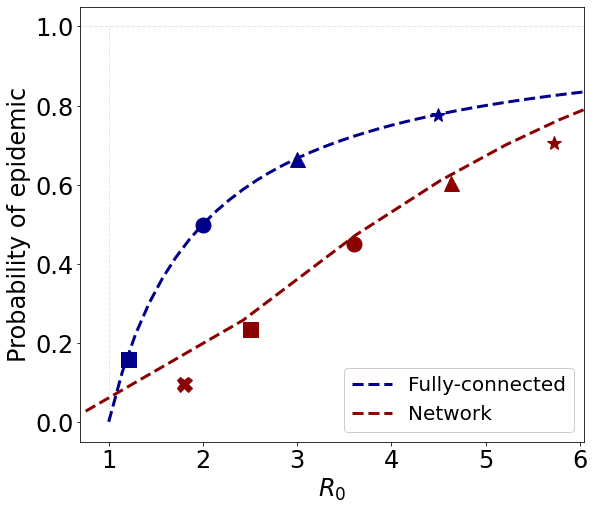

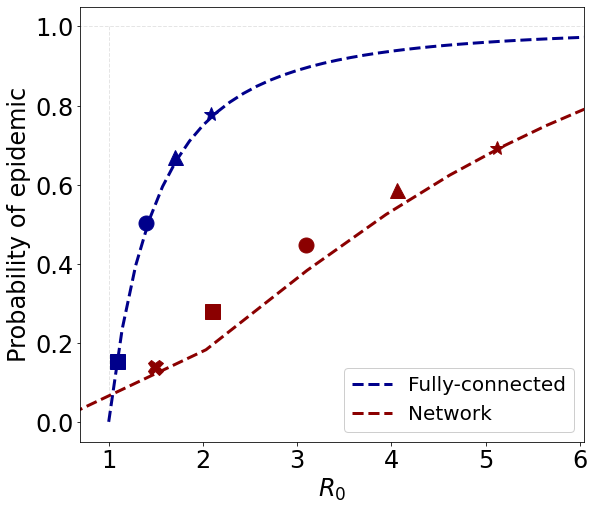

In [11]:
from scipy.stats import expon
gamma = 1/6
beta_array2 = np.linspace(0.3*gamma, 8*gamma, 10)
u = np.linspace(0.00005,0.9,100000)
#----Critical occupancy----
T_c = meanDegree/(meanDegree2-meanDegree)

Ts_SIR = 1-((meanDegree)/((meanDegree+((beta_array2)/(gamma)))))
Ts_SEIR = 1-((meanDegree)/(meanDegree+((beta_array2)*2*(gamma+(1/4))**(-1))))
u_sol_SIR = np.array([u[np.array([np.sum(p_k*k*(1+(i-1)*j)**(k-1)) for i in u])>(np.sum(p_k*k)*u)][-1] for j in Ts_SIR])
u_sol_SEIR = np.array([u[np.array([np.sum(p_k*k*(1+(i-1)*j)**(k-1)) for i in u])>(np.sum(p_k*k)*u)][-1] for j in Ts_SEIR])
S_SIR = 1 - np.array([np.sum(p_k*(1+(i-1)*j)**k) for (i, j) in zip(u_sol_SIR, Ts_SIR)])
S_SEIR = 1 - np.array([np.sum(p_k*(1+(i-1)*j)**(k)) for (i, j) in zip(u_sol_SEIR, Ts_SEIR)])


N = 2000
ps = [1,0]
sigmas = [1000, 1/4]
gamma = 1/6
R0_array = np.linspace(1, 8, 50)
R0s_p1 = np.array([4.5, 3.0, 2.0, 1.2])
R0s_p0 = np.array([4.5, 3.0, 2.0, 1.2, 0.8])
markersR0 = ['*', '^', 'o', 's', 'X']
betas1 = R0s_p1*gamma
betas2 = R0s_p0*gamma
betas_p = np.array([betas1, betas2])
R0s_SIR_p = np.array([R0s_p1, (1-((4)/((4+((betas2)/(gamma))))))/T_c])
R0s_SEIR_p = np.array([np.sqrt(1-4*(((1/4)*gamma-(1/4)*betas1)/((1/4)+gamma)**2)), (1-((4)/(4+((betas2)*2*(gamma+(1/4))**(-1)))))/T_c])
R0s_all = np.array([R0s_SIR_p, R0s_SEIR_p])

colors_R = plt.cm.Paired(range(7))
colors_p = ['darkblue', 'darkred']
lines_symbols = ['Symbols']
labels_symbols = ['Simulation']
labels_model = ['SIR', 'SEIR']

for l, sigma in enumerate(sigmas):
    fig, ax = plt.subplots(figsize = (10,8), gridspec_kw={'left':.2})
    if(sigma==1/4):
        ax.set_title('SEIR model', fontsize = 28)
    if(sigma==1000):
        ax.set_title('SIR model', fontsize = 28)
    R0s_p = R0s_all[l]
    for p, betas, R0s, color_p in zip(ps, betas_p, R0s_p, colors_p):
        
        p_epi_array = np.array([])
        i_b = 0
        for beta, R0, color in zip(betas, R0s, colors_R):
            #----Edge Occupancy probability----

            tau = 1/gamma
            data_nodes = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/stats_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma, sigma, N, p))
            data_I = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma, sigma, N, p))
            nodes_ext , nodes_succ, I_ext, I_succ, max_values = sort_nodes(p=p, beta=beta, sigma=sigma, gamma=gamma, data_I = data_I, data_nodes = data_nodes)
            
            if(sigma==1/4):
                tau = 2*((gamma)+(sigma))**(-1)
            s = ((R0)-1)
            
            #n_epi = len(max_values[max_values>(1/(s/tau))])
            #n_ext = len(max_values[max_values<(1/(s/tau))])
            
            n_epi = len(nodes_succ[:,0])
            n_ext = len(nodes_ext[:,0])
            
            n_total = n_epi + n_ext
            p_epi_array = np.append(p_epi_array, (n_epi)/n_total)
            
            ax.plot(R0, p_epi_array[-1], marker = markersR0[i_b], color = color_p, ms = 15, linestyle = '')
            i_b +=1
        
        if(p==1.0):
            if(sigma==1000):
                ax.plot(R0_array, 1-((1/R0_array)),linestyle = 'dashed', linewidth = 3, color = color_p, label = 'Fully-connected')
            if(sigma==1/4):
                ax.plot(R0_array, 1-((1/R0_array)**2),linestyle = 'dashed', linewidth = 3, color = color_p, label = 'Fully-connected')
        if(p==0.0):
            if(sigma==1000):
                R0_N_array2 = Ts_SIR/T_c
                ax.plot(R0_N_array2, S_SIR ,linestyle = 'dashed', linewidth = 3, color = color_p, label = r'Network')
            if(sigma==1/4):
                R0_N_array2 = Ts_SEIR/T_c
                ax.plot(R0_N_array2, S_SEIR ,linestyle = 'dashed', linewidth = 3, color = color_p, label = r'Network')
        
    ax.hlines(1,0.5,6.5, linestyle = 'dashed', color = 'silver', alpha = .4, linewidth = 1)
    ax.vlines(1,0,1, linestyle = 'dashed', color = 'silver', alpha = .4, linewidth = 1)
    my_plot_layout(ax=ax, xlabel = r'$R_0$', ylabel=r'Probability of epidemic')
    ax.set_xlim(0.7,6.05)
    ax.set_ylim(-0.05, 1.05)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(np.concatenate((lines_symbols,handles)), np.concatenate((labels_symbols,labels)) , fontsize = 20, loc = 4, framealpha=.95)
    fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/Prob_epi_'+labels_model[l]+'.pdf')


In [ ]:
beta = np.linspace(1.2*gamma, 4.5*gamma, 10)
t = 1-np.array([np.sum(p_k*((k)/(k+(b/gamma)))) for b in beta])
u = np.array([u[np.array([np.sum(p_k*k*(1+(i-1)*j)**(k-1)) for i in u])>(np.sum(p_k*k)*u)][-1] for j in t])

plt.plot(beta, 1 - (4/(4+ (beta/gamma))), label = '1')
plt.plot(beta, t, label = '2')
plt.plot(beta, 1-u, label = 'u')

u_sol_SIR = np.array([u[np.array([np.sum(p_k*k*(1+(i-1)*j)**(k-1)) for i in u])>(np.sum(p_k*k)*u)][-1] for j in Ts_SIR])


plt.legend()

In [ ]:
%time np.size(np.arange(5))

In [ ]:
%time len(np.arange(5))

In [ ]:
np.reshape([1,2,3,4,5,6], (3,2))

In [ ]:
from matplotlib.ticker import FormatStrFormatter
FormatStrFormatter('%.2f').format_ticks([12,3])

In [ ]:
2*((1/6)+(1/4))**(-1)

In [ ]:
1/((1/6)+(10000))

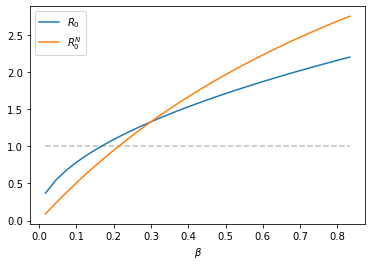

In [52]:
betas = np.linspace(0.1, 5, 30)*gamma
sigma = 1/4
gamma = 1/6
meanDegree = 6
T_c = meanDegree/(meanDegree2-meanDegree)

R0s = np.sqrt(1-4*((sigma*gamma-sigma*betas)/(sigma+gamma)**2))
R0Ns = (1-((meanDegree)/(meanDegree+((betas)*2*(gamma+sigma)**(-1)))))/T_c
plt.plot(betas, R0s, label = r'$R_0$')
plt.plot(betas, R0Ns, label = r'$R^N_0$')
plt.xlabel(r'$\beta$')
plt.hlines(1, 0.1*gamma, 5*gamma, linestyle = '--', color = 'silver')
plt.legend()

In [ ]:
print(meanDegree2)